## Visualizing crime statistics in LA

### Goal: 
To understand the crime landscape in LA by answering the following questions.
##### What are most recurring crimes in LA?
##### Is the police response a match for the criminal activity?
##### Does the LA police deparment seems to follow a strategy based on data to mitigate crime?

In [47]:
#We start by importing our dependencies
import pandas as pd
from help_functions import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})

In [34]:
# Loading csv files into dataframes
path = 'los-angeles-crime-arrest-data/'
cri = pd.read_csv(path + 'crime-data.csv', encoding='utf-8')
arr = pd.read_csv(path + 'arrest-data.csv', encoding='utf-8')

In [35]:
# Preparing date variables to be able to compare accross databases
cri = prepare_data(cri)
arr = prepare_data(arr)

### 1. What are most recurring crimes in LA?
Let's start with question 1.

In [4]:
print('This analysis takes data from the LA Police department crimes reports from {}, until {}.'.format(cri.date.min(), cri.date.max()))
print('The final table contains {} cases.'.format(cri.shape[0]))
print('The LA police identifies in its database {} types of crimes.'.format(cri['Crime Code'].value_counts().shape[0]))

This analysis takes data from the LA Police department crimes reports from 2018-12-25 00:00:00, until 2019-06-22 00:00:00.
The final table contains 103181 cases.
The LA police identifies in its database 130 types of crimes.


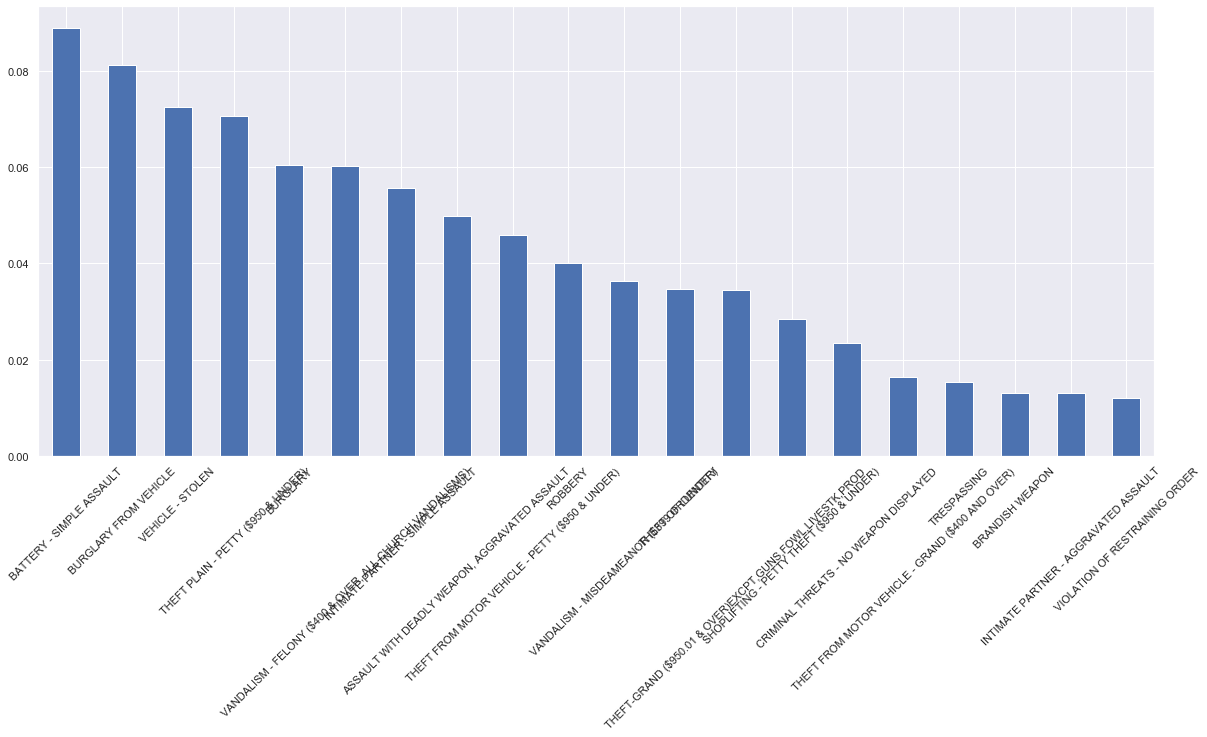

In [7]:
most_frequent_crimes = cri['Crime Code Description'].value_counts().head(20) / cri['Crime Code'].value_counts().sum()
chart = most_frequent_crimes.plot.bar()
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

At first glance, the first hurdle to analyse paterns in crime is the high detail in the typification of crimes: 130 possible offences. As the previous graph shows, some crimes could be grouped together (like different types of burglaries and thefts). Currently, there is only one type of crime that accounts for more than 10% of the total incidents, and even this seems a bit too broad "Miscellaneous Other Violations".

Following an analysis of how the policie typifies crimes, I relabeled the crime description code, based on the variable 'Charge Group Description', from the arrests database. We could benefit in two ways from this: first, we would have broader categories for types of crimes, allowing us to identify the main problems in the city; second, we could have consistency across the crime and arrests database. 

The next graph is the same graph as above, but after relabeling the most recurrent crimes. 

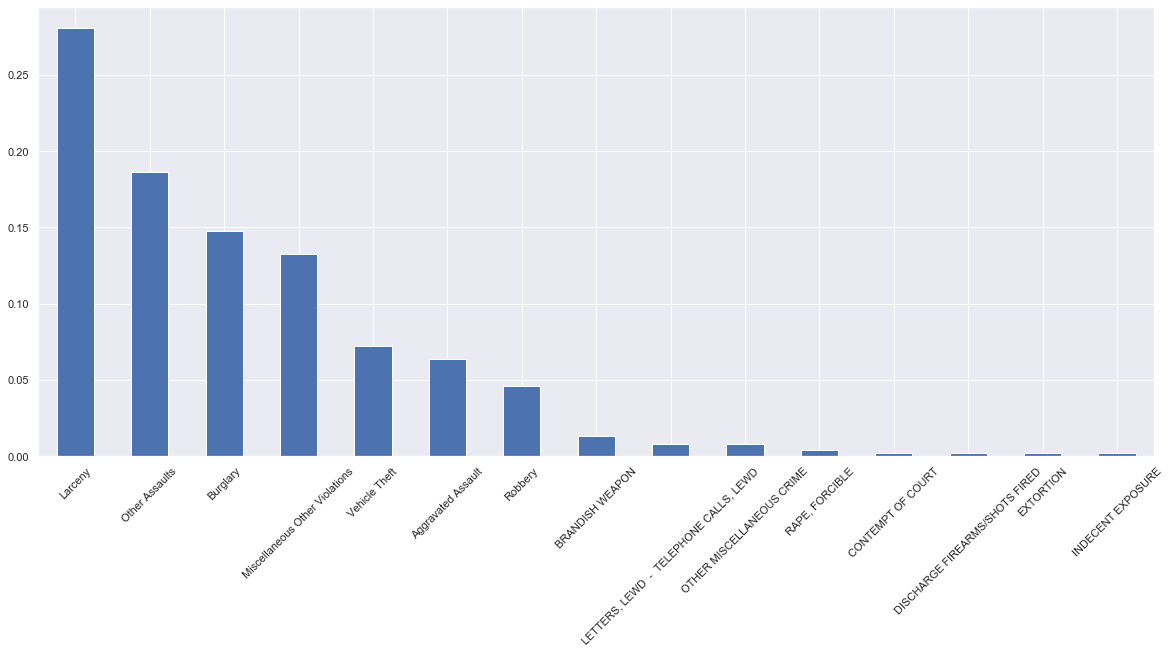

In [8]:
most_frequent_crimes = cri['crime_description_recoded'].value_counts().head(15) / cri['crime_description_recoded'].value_counts().sum()
chart = most_frequent_crimes.plot.bar()
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

As we can see, when we regroup the crime descriptions, it becomes evident that there are six types of crimes that account for more than 80% of the criminal activity. In particular, larceny alone accounts for about a third of all crime. It's noteworthy that most of the thefts are non violent. Larceny implies the theft of property, but not directly from its owner; and burglary implies that somebody entered a building to take something, but again, they are not like robbery, which implies that somebody was taking from someone using force. [references: see here](https://www.criminaldefenselawyer.com/resources/criminal-defense/criminal-offense/differences-between-theft-burglary-robbery)

In [9]:
top_crimes = cri['crime_description_recoded'].value_counts().head(5).index

Let's take a look from another angle: the weekly pattern of criminal activity. Criminal activity, on average, seems to be almost evenly distributed throughout the week.  The day of the week is Sunday, and then it grows gradually, to hit a peak on fridays. Then saturday goes down again. 

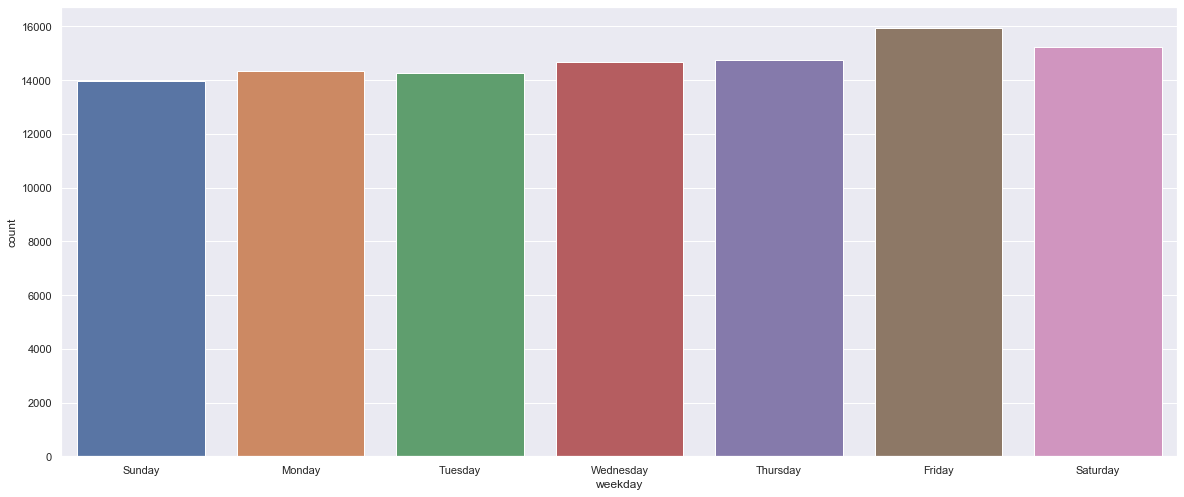

In [10]:
ax = sns.countplot(x="weekday", data=cri, order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

In [11]:
top_crimes

Index(['Larceny', 'Other Assaults', 'Burglary',
       'Miscellaneous Other Violations', 'Vehicle Theft'],
      dtype='object')

When we limit the analysis by day of the week to the top six crimes, as defined above, there are some interesting findings. Friday is the top day for two of the most prevalent crimes: burglary and larceny. Without doing too much research, one could speculate that this is the day of the week that most people go out for dinner or entertainment, living their homes unattended, and are probably less careful about their belongings. For aggravated and other types of assault, perhaps the most worrysome crime in this bundle because it implies violence, the peak occurs on weekends both saturday and sunday. 

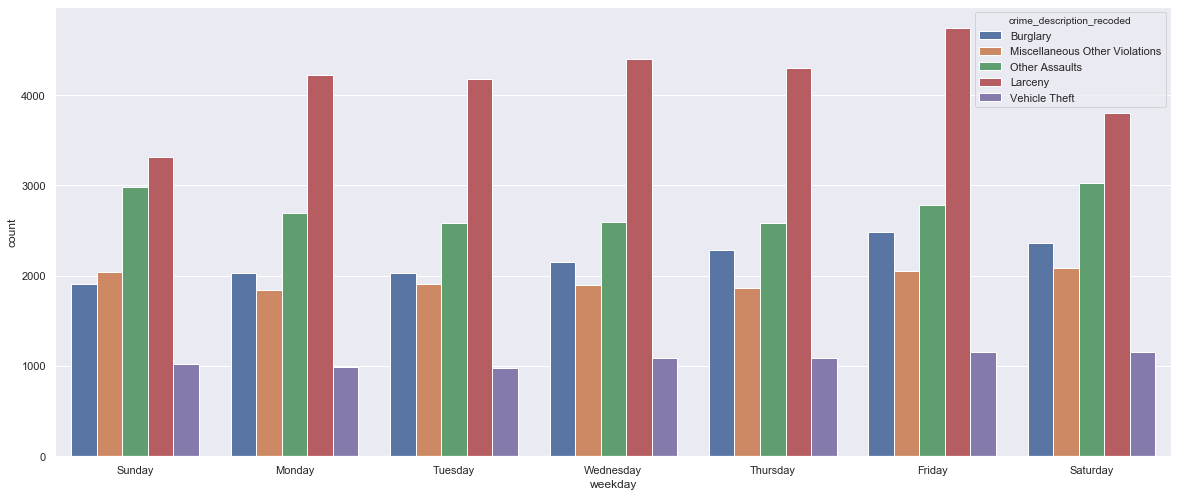

In [12]:
ax = sns.countplot(x="weekday", data=cri[cri['crime_description_recoded'].isin(top_crimes)], hue = 'crime_description_recoded', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

To answer question 1 (**What are most recurring crimes in LA?**): The most reccurent crime in LA is burglary, with more than 36 thousand cases every six months. Along with assaults, and burglaries, they account for moe than 70% of the criminal activity. As we can see, these crimes share in common that they show an even distritution during the weekd days, and an increase toward the weekend. Activities related to stealing property, like burglary and larceny, reak a peak on fridays; assaults, aggravated and other types, occur more often on Saturdays and Sundays. 

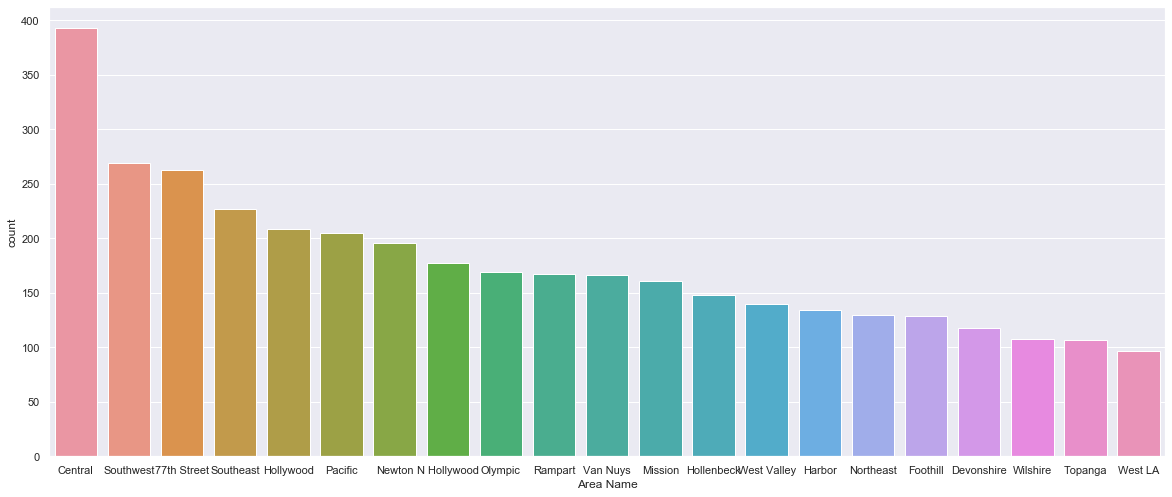

In [13]:
data = arr[arr['Charge Group Description']=='Other Assaults']#'Aggravated Assault']
ax = sns.countplot(x='Area Name', data= data, order = data['Area Name'].value_counts().index)

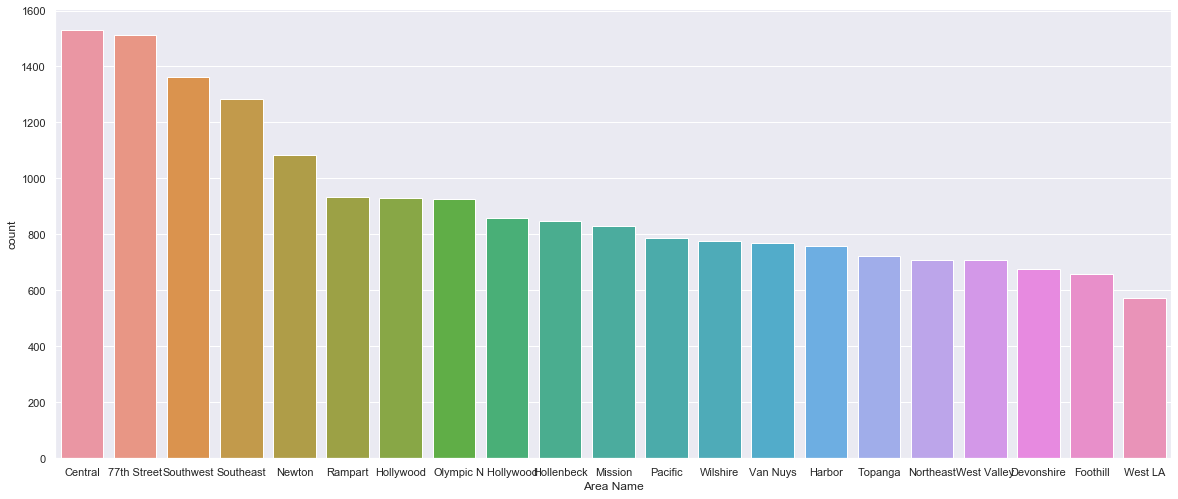

In [57]:
data = cri[cri['crime_description_recoded']=='Other Assaults']#Aggravated Assault']
ax = sns.countplot(x='Area Name', data= data, order = data['Area Name'].value_counts().index)

### Is the police response a match for the criminal activity?


In [14]:
arr_cri_ratio = arr.shape[0]/cri.shape[0]
print('This analysis takes data from the LA Police department arrests reports from {}, until {}.'.format(arr.date.min(), arr.date.max()))
print('The final table contains {} cases. Namely, the ratio of arrests to crimes reported is {}.'.format(arr.shape[0], arr_cri_ratio))
print('The LA police identifies in its database {} types of charge groups, and {} types of charges.'.format(arr['Charge Group Description'].value_counts().shape[0], arr['Charge Description'].value_counts().shape[0]))


This analysis takes data from the LA Police department arrests reports from 2018-12-25 00:00:00, until 2019-06-22 00:00:00.
The final table contains 45720 cases. Namely, the ratio of arrests to crimes reported is 0.44310483519252575.
The LA police identifies in its database 27 types of charge groups, and 835 types of charges.


So, about for every two reported crimes, there isapproximately one arrest. Initially, it can be assumed that multiple reports could be linked to one case, so this number might not be labeled as 'low'. Let's turn to see if what are the most types of arrest.

In [15]:
top_arrests = arr['Charge Group Description'].value_counts().head(6).index

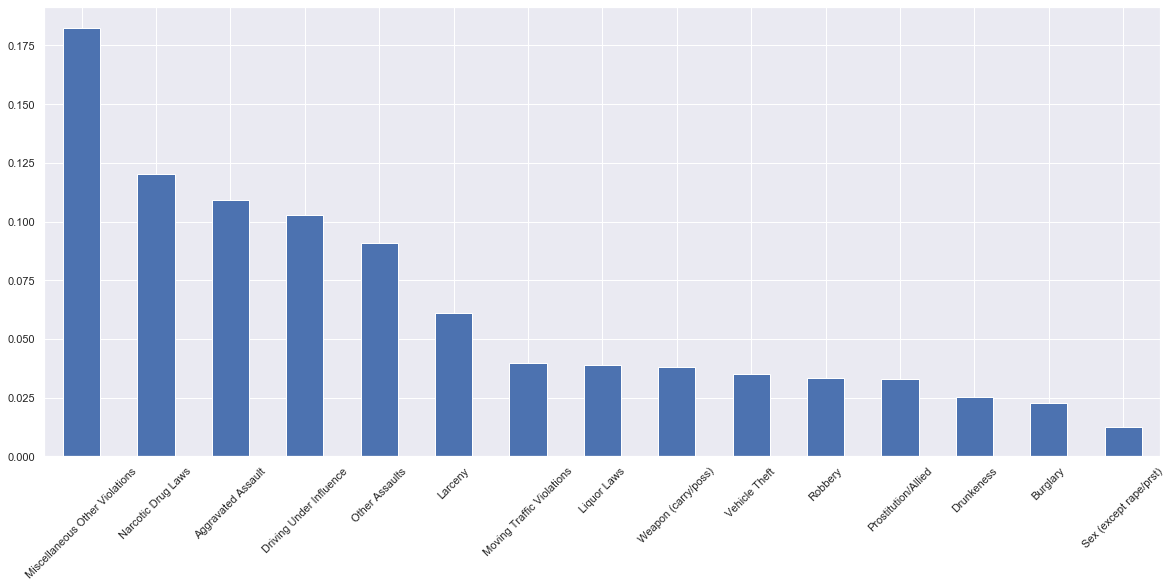

In [16]:
most_frequent_arrests = arr['Charge Group Description'].value_counts().head(15) / arr['Charge Group Description'].value_counts().sum()
chart = most_frequent_arrests.plot.bar()
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

The most frequent type of arrest goes to the group "Miscellaneous Other Violations", with 17% of the cases. This category includes parole violations, failure to pay, and vandalism. Next are "Narcotic Drug Laws", "Aggravated Assault", "Driving Under Influence" and "Other assaults. From the top five charge group descriptions, two overlap with most frequent type of crimes: both types of assaults. Larceny, which is the top crime, represents less than 7% of arrests.

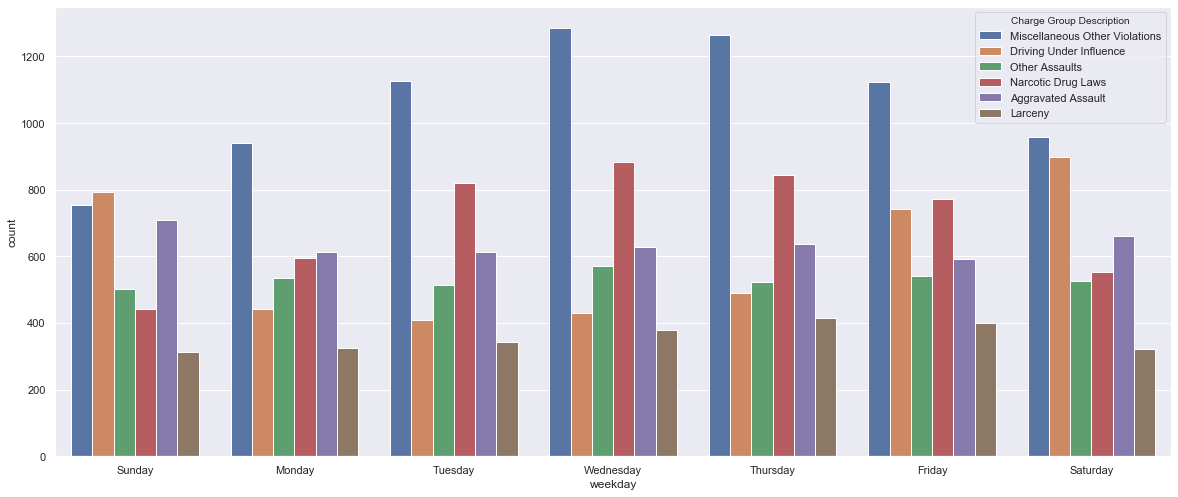

In [28]:
ax = sns.countplot(x="weekday", data=arr[arr['Charge Group Description'].isin(top_arrests)], hue = 'Charge Group Description', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])



In [ ]:
data = cri[cri['crime_description_recoded'].isin(top_crimes)]
ax = sns.countplot(x='Area Name', data= data, order = data['Area Name'].value_counts().index)

In [76]:
cri['Crime Code Description'].value_counts()

Miscellaneous Other Violations                              13671
BATTERY - SIMPLE ASSAULT                                     9184
BURGLARY FROM VEHICLE                                        8392
VEHICLE - STOLEN                                             7487
THEFT PLAIN - PETTY ($950 & UNDER)                           7289
BURGLARY                                                     6232
INTIMATE PARTNER - SIMPLE ASSAULT                            5735
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT               5144
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)              4747
ROBBERY                                                      4129
THEFT OF IDENTITY                                            3571
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD     3555
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                     2932
CRIMINAL THREATS - NO WEAPON DISPLAYED                       2426
THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)             1696
BRANDISH W

In [39]:
arr.columns

Index(['Unnamed: 0', 'Report ID', 'Arrest Date', 'Time', 'Area ID',
       'Area Name', 'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Address', 'Cross Street', 'Location',
       'Zip Codes', 'Census Tracts', 'Precinct Boundaries',
       'LA Specific Plans', 'Council Districts',
       'Neighborhood Councils (Certified)', 'date', 'week', 'weekday'],
      dtype='object')

In [4]:
# creating a table of incidents per day
table_week = pd.DataFrame()
table_week['crime'] = cri.groupby('week').size()
table_week['arrests'] = arr.groupby('week').size()

In [36]:
cri.columns

Index(['Unnamed: 0', 'DR Number', 'Date Reported', 'Date Occurred',
       'Time Occurred', 'Area ID', 'Area Name', 'Reporting District',
       'Crime Code', 'Crime Code Description', 'MO Codes', 'Victim Age',
       'Victim Sex', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location ', 'date', 'week',
       'weekday'],
      dtype='object')

In [ ]:
cri['Status Description'].value_counts() /cri['Status Description'].value_counts().sum()

In [55]:
cri[['Date Reported','Date Occurred', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4']].tail()

,Date Reported,Date Occurred,Victim Descent,Premise Code,Premise Description,Weapon Used Code,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4
1993254,6242019-01-01T00:00:00,2019-06-21T00:00:00,X,404.0,DEPARTMENT STORE,NaN,NaN,IC,Invest Cont,442.0,NaN,NaN,NaN
1993255,1152019-01-01T00:00:00,2019-01-15T00:00:00,H,101.0,STREET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AA,Adult Arrest,910.0,NaN,NaN,NaN
1993256,2022019-01-01T00:00:00,2019-02-01T00:00:00,X,101.0,STREET,NaN,NaN,IC,Invest Cont,946.0,998.0,NaN,NaN
1993257,4262019-01-01T00:00:00,2019-02-05T00:00:00,NaN,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont,668.0,NaN,NaN,NaN
1993258,4262019-01-01T00:00:00,2019-01-07T00:00:00,NaN,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont,668.0,NaN,NaN,NaN


In [18]:
cri['Crime Code Description'].value_counts().head() / float(cri['Crime Code Description'].value_counts().sum())


AttributeError: 'int' object has no attribute 'head'

In [16]:
cri['Crime Code Description'].value_counts().head(10)

BATTERY - SIMPLE ASSAULT                                   9184
BURGLARY FROM VEHICLE                                      8392
VEHICLE - STOLEN                                           7487
THEFT PLAIN - PETTY ($950 & UNDER)                         7289
BURGLARY                                                   6232
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    6226
INTIMATE PARTNER - SIMPLE ASSAULT                          5735
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             5144
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)            4747
ROBBERY                                                    4129
Name: Crime Code Description, dtype: int64

In [22]:
arr['Charge Description'].value_counts().head(10)

DRUNK DRIVING ALCOHOL/DRUGS                 95410
DRINKING IN PUBLIC                          92965
CORPORAL INJURY ON SPOUSE/COHABITANT/ETC    44812
POSSESSION CONTROLLED SUBSTANCE             43697
FTA AFTER WRITTEN PROMISE                   31177
POSSESSION NARCOTIC CONTROLLED SUBSTANCE    29352
PROSTITUTION                                26169
OPEN ALCOHOLIC BEV IN PUBLIC PARK/PLACE     25668
SIT/LIE/SLEEP SIDEWALK OR STREET            25573
LOS ANGELES MUNICIPAL CODE                  24367
Name: Charge Description, dtype: int64

In [29]:
arr.columns

Index(['Report ID', 'Arrest Date', 'Time', 'Area ID', 'Area Name',
       'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Address', 'Cross Street', 'Location',
       'Zip Codes', 'Census Tracts', 'Precinct Boundaries',
       'LA Specific Plans', 'Council Districts',
       'Neighborhood Councils (Certified)'],
      dtype='object')

In [31]:
arr[['Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description','LA Specific Plans']].head()

,Sex Code,Descent Code,Charge Group Code,Charge Group Description,Arrest Type Code,Charge,Charge Description,LA Specific Plans
0,M,W,24.0,Miscellaneous Other Violations,M,594(A)PC,VANDALISM,10.0
1,M,O,NaN,NaN,O,300(B)WIC,NaN,NaN
2,F,O,22.0,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,17.0
3,F,W,22.0,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,NaN
4,M,W,8.0,Other Assaults,F,69PC,OBSTRUCT/RESIST EXECUTIVE OFFICER,10.0


In [121]:
cri.columns

Index(['Unnamed: 0', 'DR Number', 'Date Reported', 'Date Occurred',
       'Time Occurred', 'Area ID', 'Area Name', 'Reporting District',
       'Crime Code', 'Crime Code Description', 'MO Codes', 'Victim Age',
       'Victim Sex', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location '],
      dtype='object')

In [9]:
arr.columns

Index(['Unnamed: 0', 'Report ID', 'Arrest Date', 'Time', 'Area ID',
       'Area Name', 'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Address', 'Cross Street', 'Location',
       'Zip Codes', 'Census Tracts', 'Precinct Boundaries',
       'LA Specific Plans', 'Council Districts',
       'Neighborhood Councils (Certified)'],
      dtype='object')

In [26]:
arr['Arrest Type Code'].value_counts() / arr.shape[0]

M    0.530840
F    0.367782
I    0.072178
O    0.023885
D    0.005315
Name: Arrest Type Code, dtype: float64

In [17]:
arr['br'] = arr['Charge Description'].str.contains('|'.join(['BRANDISH']))

In [18]:
arr[arr['br']==1][['Charge Description', 'Charge Group Description']]

,Charge Description,Charge Group Description
41364,BRANDISH F/ARM REPLICA AT OCCUPANT OF VEH,Aggravated Assault
41399,BRANDISH F/ARM REPLICA AT OCCUPANT OF VEH,Aggravated Assault


In [39]:
arr.columns

Index(['Unnamed: 0', 'Report ID', 'Arrest Date', 'Time', 'Area ID',
       'Area Name', 'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Address', 'Cross Street', 'Location',
       'Zip Codes', 'Census Tracts', 'Precinct Boundaries',
       'LA Specific Plans', 'Council Districts',
       'Neighborhood Councils (Certified)'],
      dtype='object')

In [8]:
cri.columns


Index(['Unnamed: 0', 'DR Number', 'Date Reported', 'Date Occurred',
       'Time Occurred', 'Area ID', 'Area Name', 'Reporting District',
       'Crime Code', 'Crime Code Description', 'MO Codes', 'Victim Age',
       'Victim Sex', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location ', 'date'],
      dtype='object')

In [19]:
arr.head()

,Unnamed: 0,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Location,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified),date,week,weekday
0,0,5666847,2019-06-22,1630.0,14,Pacific,1457,44,M,W,...,"{'latitude': '33.992', 'human_address': '{""add...",24031.0,918.0,1137.0,10.0,10.0,85.0,2019-06-22,2019-w24,Saturday
1,1,5666688,2019-06-22,1010.0,10,West Valley,1061,8,M,O,...,"{'latitude': '34.1687', 'human_address': '{""ad...",19339.0,321.0,1494.0,NaN,4.0,10.0,2019-06-22,2019-w24,Saturday
2,2,5666570,2019-06-22,400.0,15,N Hollywood,1543,31,F,O,...,"{'latitude': '34.1649', 'human_address': '{""ad...",8890.0,205.0,1332.0,17.0,5.0,39.0,2019-06-22,2019-w24,Saturday
3,3,5666529,2019-06-22,302.0,17,Devonshire,1738,23,F,W,...,"{'latitude': '34.2692', 'human_address': '{""ad...",19329.0,69.0,388.0,NaN,2.0,78.0,2019-06-22,2019-w24,Saturday
4,4,5666742,2019-06-22,1240.0,14,Pacific,1472,28,M,W,...,"{'latitude': '33.9609', 'human_address': '{""ad...",25075.0,937.0,241.0,10.0,10.0,16.0,2019-06-22,2019-w24,Saturday


In [46]:
arr[arr['Charge Group Description']=='Aggravated Assault']['Charge Description'].value_counts()

CORPORAL INJURY ON SPOUSE/COHABITANT/ETC     2227
ADW, NOT FIREARM, W/GBI                      1191
ASSAULT LIKELY TO PRODUCE GBI                 187
ADW W/FIREARM                                 173
BATTERY W/GBI                                 135
ATTEMPT - MURDER                              129
INJURING A SPOUSE/COHABITANT, ETC W/PRIOR      88
CRUEL TO CHILD LIKELY TO PROD GBI/DEATH        50
CAUSE HARM/DEATH OF ELDER/DEPEND ADULT         40
ADW PO/FIREMAN W/O FIREARM/GBI                 35
ADW W/O FIREARM/GBI                            27
ADW W/SEMIAUTOMATIC RIFLE                      23
THROW SUBSTANCE AT VEHICLE W/GBI INTENT        23
ARSON INHABITED STRUCTURE/PROPERTY             22
BATT ON SCHL EMPLOYEE/RETALIATION W/INJ        17
MAYHEM                                         15
DRAW/EXHIBIT IMITATION FIREARM                 12
EXHIBIT/DRAW FIREARM                           10
CORPORAL INJURY ON CHILD                        9
INFLICT BODILY HARM/DEATH ON ELDER ADULT        6


In [61]:
arrests = arr[arr['Charge Group Description'].isin(top_crimes)]['Charge Group Description'].value_counts().sort_index()

In [62]:
crimes = cri[cri['crime_description_recoded'].isin(top_crimes)]['crime_description_recoded'].value_counts().sort_index()

In [63]:
crimes


Aggravated Assault     6545
Burglary              15237
Larceny               28952
Other Assaults        19241
Vehicle Theft          7487
Name: crime_description_recoded, dtype: int64

In [65]:
ratio = arrests/crimes

In [68]:
ratio.sort_values(ascending=False)

Aggravated Assault    0.680519
Other Assaults        0.192973
Vehicle Theft         0.192066
Larceny               0.086177
Burglary              0.060314
dtype: float64

In [17]:
cri['crime_description_recoded'].value_counts()

Larceny                                                     28952
Other Assaults                                              19241
Burglary                                                    15237
Miscellaneous Other Violations                              13671
Vehicle Theft                                                7487
Aggravated Assault                                           6545
Robbery                                                      4727
BRANDISH WEAPON                                              1346
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD                       829
OTHER MISCELLANEOUS CRIME                                     816
RAPE, FORCIBLE                                                398
CONTEMPT OF COURT                                             241
DISCHARGE FIREARMS/SHOTS FIRED                                234
EXTORTION                                                     207
INDECENT EXPOSURE                                             193
DISTURBING

In [36]:
arr = arr.dropna(subset=['Charge Description'])

In [54]:
arr[arr['Charge Description'].str.contains('EXTORTION')][['Charge Group Description', 'Charge Description']]

,Charge Group Description,Charge Description
1416,Miscellaneous Other Violations,EXTORTION
1634,Miscellaneous Other Violations,ATTEMPTED EXTORTION
11105,Miscellaneous Other Violations,ATTEMPTED EXTORTION
19285,Miscellaneous Other Violations,EXTORTION
29991,Miscellaneous Other Violations,EXTORTION
36432,Miscellaneous Other Violations,EXTORTION
40944,Miscellaneous Other Violations,EXTORTION
44954,Miscellaneous Other Violations,EXTORTION
